In [1]:
#from google.colab import files
#для работы нейронной сети

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras import utils, layers
from tensorflow.keras.optimizers import Adam #, SGD, RMSProp
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, MaxPooling1D, ZeroPadding1D, GlobalMaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D, Activation, Conv2DTranspose, MaxPooling2D, add, SeparableConv2D, UpSampling2D, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import backend as K #для работы с лоссом и метрикой
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img, save_img, smart_resize
from PIL import Image
#from sklearn.model_selection import train_test_split
#from tensorflow.keras.preprocessing.image import ImageDataGenerator # создаём генераторы для обучения
#import albumentations as A

# для загрузки изображений и аугментации
import imageio
import cv2
from matplotlib import pyplot as plt
import random
random.seed(2)

#лля математической обработки данных
import pandas as pd
import numpy as np
#для вызова прямо в среде программирования команд операционной оболочки
import os
import os.path
#для построения графиков

%matplotlib inline

import io # input-output, для работы с файлами
#from sklearn.preprocessing import StandardScaler
from pathlib import Path
import h5py as h5

import zipfile 
from collections import Counter


In [2]:
import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
import tensorflow as tf


In [4]:
from torch.utils.data import Dataset

In [5]:
from torchvision import datasets, models, transforms


from PIL import Image

In [6]:
from google.colab import files
v= files.upload()

for fn in v.keys():
       print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(v[fn])))

Saving 1.zip to 1.zip
Saving 102.zip to 102.zip
User uploaded file "1.zip" with length 30488237 bytes
User uploaded file "102.zip" with length 5401105 bytes


In [7]:
DIR_TRAIN = "/content/train/1/crop2_DJI_0481"
DIR_TEST = "/content/test/102/crop_DJI_0490"

PATH_TRAIN = "/content/train.csv"
PATH_TEST = "/content/test.csv"

In [8]:
!mkdir "/content/test"

In [9]:
!mkdir "/content/train"

In [15]:
!unzip 1.zip -d /content/train/

Archive:  1.zip
   creating: /content/train/1/
   creating: /content/train/1/crop1_DJI_0002/
  inflating: /content/train/1/crop1_DJI_0002/crop1_DJI_0002_1.jpg  
  inflating: /content/train/1/crop1_DJI_0002/crop1_DJI_0002_1.png  
  inflating: /content/train/1/crop1_DJI_0002/crop1_DJI_0002_15.jpg  
  inflating: /content/train/1/crop1_DJI_0002/crop1_DJI_0002_15.png  
  inflating: /content/train/1/crop1_DJI_0002/crop1_DJI_0002_23.jpg  
  inflating: /content/train/1/crop1_DJI_0002/crop1_DJI_0002_23.png  
  inflating: /content/train/1/crop1_DJI_0002/crop1_DJI_0002_30.jpg  
  inflating: /content/train/1/crop1_DJI_0002/crop1_DJI_0002_30.png  
  inflating: /content/train/1/crop1_DJI_0002/crop1_DJI_0002_38.jpg  
  inflating: /content/train/1/crop1_DJI_0002/crop1_DJI_0002_38.png  
  inflating: /content/train/1/crop1_DJI_0002/crop1_DJI_0002_45.jpg  
  inflating: /content/train/1/crop1_DJI_0002/crop1_DJI_0002_45.png  
  inflating: /content/train/1/crop1_DJI_0002/crop1_DJI_0002_53.jpg  
  inflating:

In [10]:
!unzip 102.zip -d /content/test/

Archive:  102.zip
   creating: /content/test/102/
   creating: /content/test/102/crop_DJI_0490/
  inflating: /content/test/102/crop_DJI_0490/crop_DJI_0490_1.jpg  
  inflating: /content/test/102/crop_DJI_0490/crop_DJI_0490_1.png  
  inflating: /content/test/102/crop_DJI_0490/crop_DJI_0490_1001.jpg  
  inflating: /content/test/102/crop_DJI_0490/crop_DJI_0490_1001.png  
  inflating: /content/test/102/crop_DJI_0490/crop_DJI_0490_101.jpg  
  inflating: /content/test/102/crop_DJI_0490/crop_DJI_0490_101.png  
  inflating: /content/test/102/crop_DJI_0490/crop_DJI_0490_1013.jpg  
  inflating: /content/test/102/crop_DJI_0490/crop_DJI_0490_1013.png  
  inflating: /content/test/102/crop_DJI_0490/crop_DJI_0490_1026.jpg  
  inflating: /content/test/102/crop_DJI_0490/crop_DJI_0490_1026.png  
  inflating: /content/test/102/crop_DJI_0490/crop_DJI_0490_1038.jpg  
  inflating: /content/test/102/crop_DJI_0490/crop_DJI_0490_1038.png  
  inflating: /content/test/102/crop_DJI_0490/crop_DJI_0490_1051.jpg  
  

In [11]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, label = self.data_df.iloc[idx]['index'], self.data_df.iloc[idx]['class']

        # читаем картинку. read the image
        image = cv2.imread(DIR_TRAIN + f"{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label).long()
    
    def __len__(self):
        return len(self.data_df)

In [12]:
train_transform = transforms.Compose([
    #transforms.Resize(256),
    transforms.RandomResizedCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    #transforms.Resize(256),
    transforms.RandomResizedCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

In [13]:
from os import listdir

print("Обучающей выборки " ,len(listdir(DIR_TRAIN)))
print("Тестовой выборки " ,len(listdir(DIR_TEST)))

FileNotFoundError: ignored

In [16]:
import numpy as np
import cv2
import os

IMG_DIR = '/content/train/1/crop2_DJI_0481'

for img in os.listdir(IMG_DIR):
        img_array = cv2.imread(os.path.join(IMG_DIR,img), cv2.IMREAD_GRAYSCALE)

        img_array = (img_array.flatten())

        img_array  = img_array.reshape(-1, 1).T

        print(img_array)

        with open('output.csv', 'ab') as f:

            np.savetxt(f, img_array, delimiter=",")

[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]
[[  0   0   0 ... 255 255 255]]
[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]
[[63 63 63 ... 53 53 54]]
[[0 0 0 ... 0 0 0]]
[[63 64 65 ... 51 51 51]]
[[62 62 62 ... 54 54 54]]
[[  0   0   0 ... 255 255 255]]
[[58 58 58 ... 49 52 54]]
[[63 63 63 ... 50 50 50]]
[[0 0 0 ... 0 0 0]]
[[58 58 58 ... 52 52 52]]
[[0 0 0 ... 0 0 0]]
[[61 61 61 ... 51 51 51]]
[[0 0 0 ... 0 0 0]]
[[60 60 60 ... 54 54 55]]
[[65 63 64 ... 54 54 54]]
[[58 59 60 ... 54 54 54]]
[[60 60 60 ... 52 52 52]]
[[ 60  60  60 ... 155 159 162]]
[[63 63 63 ... 50 50 50]]
[[63 63 63 ... 52 52 53]]
[[0 0 0 ... 0 0 0]]
[[ 60  61  61 ... 130 121 109]]
[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]
[[  0   0   0 ... 255 255 255]]
[[0 0 0 ... 0 0 0]]
[[65 65 65 ... 50 50 50]]
[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]
[[ 59  59  59 ... 100 105 108]]
[[0 0 0 ... 0 0 0]]
[[58 58 58 ... 55 56 57]]
[[0 0 0 ... 0 0 0]]
[[64 64 64 ... 52 52 52]]
[[0 0 0 ... 

In [17]:
import pandas as pd
df=pd.DataFrame(img_array).to_csv("/content/output.csv")

In [18]:
df=pd.read_csv('/content/output.csv')

In [19]:
df

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,33365,33366,33367,33368,33369,33370,33371,33372,33373,33374
0,0,59,59,59,59,59,59,60,60,60,...,57,56,56,59,77,94,114,123,117,121


In [20]:
df3=df.T

In [ ]:
df3.describe

<bound method NDFrame.describe of             class
Unnamed: 0      0
0              59
1              59
2              59
3              59
...           ...
33370          94
33371         114
33372         123
33373         117
33374         121

[33376 rows x 1 columns]>

In [166]:
class_names=np.arange(0,102,1)

In [167]:
class_names

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101])

In [ ]:
train_df, valid_df = train_test_split(df3, test_size=0.15, random_state=33)

In [ ]:
train_df=train_df/255
valid_df=valid_df/255

In [ ]:
train_df.shape, valid_df.shape

((28368, 1), (5007, 1))

In [ ]:
df3.rename(columns={0: 'class'}, inplace=True)

In [ ]:
df3.index.names = ['index']

In [168]:
#from google.colab import files
#для работы нейронной сети

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras import utils, layers
from tensorflow.keras.optimizers import Adam #, SGD, RMSProp
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, MaxPooling1D, ZeroPadding1D, GlobalMaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D, Activation, Conv2DTranspose, MaxPooling2D, add, SeparableConv2D, UpSampling2D, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import backend as K #для работы с лоссом и метрикой
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img, save_img, smart_resize
from PIL import Image
#from sklearn.model_selection import train_test_split
#from tensorflow.keras.preprocessing.image import ImageDataGenerator # создаём генераторы для обучения
#import albumentations as A

# для загрузки изображений и аугментации
import imageio
import cv2
from matplotlib import pyplot as plt
import random
random.seed(2)

#лля математической обработки данных
import pandas as pd
import numpy as np
#для вызова прямо в среде программирования команд операционной оболочки
import os
import os.path
#для построения графиков

%matplotlib inline

import io # input-output, для работы с файлами
#from sklearn.preprocessing import StandardScaler
from pathlib import Path
import h5py as h5

import zipfile 
from collections import Counter


In [198]:

w, h = 922, 307# координаты исходной картинки
wc, hc = 920, 300 # нужно чтобы размер был кратен, обрежем сначала лишнее

# раccчитаем кординаты для обрезки
box_left = int((w - wc)//2)
box_top = int((h - hc)//2)
box_right = box_left + wc
box_bottom = box_top + hc
print(box_left, box_right, box_top, box_bottom)

# уменьшим изображение вдвое при загрузке, в сети сожмём в 16 раз, 

image_size = (h, w)
inp_ratio, outp_ratio = 2, 2    # кратность сжатия картинки при загрузке
target_inp = (int(hc  / inp_ratio), int(wc  / inp_ratio)) # размер получаемой картинки
target_outp = (int(hc  / outp_ratio), int(wc  / outp_ratio))
print(target_inp, target_outp)  # выводим размеры
#neigbors = np.array([[-1, -1], [-1, 0], [-1, 1], [1, -1], [1, 0], [1, 1], [0, -1], [0, 1]])

# прописываем пути к датасету
dataset_folder = '/content/train/1/crop_DJI_0001'

mask_folder = '/content/train/1/crop1_DJI_0481'
#mask_cropped_folder = f'{dataset_folder}labels/pixel_level_labels_cropped/'
#mask_classified_folder = f'{dataset_folder}labels/pixel_level_labels_classified/'
image_folder = '/content/test/102/crop_DJI_0490/'
#image_cropped_folder = f'{dataset_folder}images_cropped/'

1 921 3 303
(150, 460) (150, 460)


In [209]:
def get_images():   #формируем выборки, входные данные это X_images, выходные - Y_images
    X_images, Y_images, Y_images_color = [], [], [] # здесь будут выборки для подачи в сеть и визуализации
    count = 1   # счётчик обработанных файлов
    files_num = 101
    images_list = sorted(os.listdir(f'{image_folder}')) # список имён файлов картинок
    masks_list = sorted(os.listdir(f'{mask_folder}'))   # список имён файлов сегментированных картинок


    for image_name, mask_name in zip(images_list, masks_list):  # берём имя файла - картинку и соответствующую маску
   
        image_path = f'{image_folder}/{image_name}'             # получаем полные пути к файлам
        mask_path = f'{mask_folder}/{mask_name}'

        image = img_to_array(load_img(image_path, target_size=image_size))[box_top:box_bottom, box_left:box_right]  # загрузили, обрезали как нужно
        image = smart_resize(image, target_inp).astype('uint8')                                                     # изменили размер

        mask = img_to_array(load_img(mask_path, target_size=image_size))[box_top:box_bottom, box_left:box_right]    # загрузили, обрезали как нужно
        mask = smart_resize(mask, target_inp).astype('uint8')                                                       # изменили размер

        mask_cat = mask_to_cat(mask)                            # переводим данные в маске в категориальные, т.е. разбиваем по классам

        X_images.append(image)                                  # создаём списки с выборками
        Y_images.append(mask_cat)
        Y_images_color.append(mask)

        print('обработаны:', image_name, ',', mask_name, ', обработано пар картинок:', count, ', осталось:', files_num - count)
        count += 1

    X_train = np.array(X_images).astype('float32') / 255.  # переводим списки в правильный формат
    Y_train = np.array(Y_images).astype('float32')
    Y_train_color = np.array(Y_images_color).astype('float32')
    print('размерность данных X_train:', X_train.shape)
    print('размерность данных Y_train:', Y_train.shape)
    print('проверим уникальные классы Y_train:', np.unique(Y_train))
    return X_train, Y_train, Y_train_color         # возвращаем готовые выборки

def mask_to_cat(mask):  # переводим данные в маске из цветовых в категориальные, т.е. разбиваем по классам
    mask_green = mask[:,:,1]  # берём массив только зелёного цвета для удобного преобразования
    mask_cat = mask_green.copy()    # создаём шаблон, в котором потом будут уже числа классов
    for idx, bright_num in enumerate(class_names): # проходим по классам с самого наименьшего
        if class_names[idx] in class_names:   # проверяем, что класс есть в списке тех, которые хотим сегментировать
            wish_flag = True                           # если да, то по флагу будем записывать значение, иначе отнесём класс к 0
        else:
            wish_flag = False
        
        if (bright_num > class_names[0]) and (bright_num < class_names[-1]): # если класс не нулевой и не последний (чтобы не было ошибки)
            # для всех значений яркости в диапазоне между предыдущим и следующим классами установим соответствующий класс
            if wish_flag:
                mask_cat[np.logical_and(idx-1<mask_cat, mask_cat<=(class_names[idx+1]+bright_num)/2)] = idx
            else:
                mask_cat[np.logical_and(idx-1<mask_cat, mask_cat<=(class_names[idx+1]+bright_num)/2)] = 0
        elif bright_num == class_names[0]: # если класс нулевой
            mask_cat[mask_cat<=(class_names[idx+1]+bright_num)/2] = 0
        elif bright_num == class_names[-1]: # если класс последний
            if wish_flag:
                mask_cat[(mask_cat>=(class_names[idx-1]+bright_num)/2)] = idx
            else:
                mask_cat[(mask_cat>=(class_names[idx-1]+bright_num)/2)] = 0
    return mask_cat

def plot_images(num, X_train, Y_train, Y_train_color): #выводим картинки, согласно номеру в массиве

    q = 10 #число картинок
    fig, ax = plt.subplots(1, q, figsize=(q*4, 15)) # создаём полотно рисунка
    fig.subplots_adjust(hspace=0, wspace=0) # настраиваем изображение
    # исходная
    ax[0].xaxis.set_major_locator(plt.NullLocator()) # убираем оси и подписи к ним
    ax[0].yaxis.set_major_locator(plt.NullLocator())
    ax[0].imshow(array_to_img(X_train[num])) # Переводим в графический форматмизображение случайно выбранного массива
    ax[0].text(0.5, X_train.shape[1] * 1.15, f"исходная", fontsize=14) # вывод текста пойдет в текущий субграфик
    # маска по классам
    ax[1].xaxis.set_major_locator(plt.NullLocator()) # убираем оси и подписи к ним
    ax[1].yaxis.set_major_locator(plt.NullLocator())
    ax[1].imshow(Image.fromarray(Y_train[num]*255/58)) # Переводим в графический форматмизображение случайно выбранного массива
    ax[1].text(0.5, Y_train.shape[1] * 1.15, f"маска", fontsize=14) # вывод текста пойдет в текущий субграфик
    # маска по цветам
    ax[2].xaxis.set_major_locator(plt.NullLocator()) # убираем оси и подписи к ним
    ax[2].yaxis.set_major_locator(plt.NullLocator())
    ax[2].imshow(array_to_img(Y_train_color[num])) # Переводим в графический форматмизображение случайно выбранного массива
    ax[2].text(0.5, Y_train_color.shape[1] * 1.15, f"обратная", fontsize=14) # вывод текста пойдет в текущий субграфик
    # маска по цветам восстановленная
    ax[3].xaxis.set_major_locator(plt.NullLocator()) # убираем оси и подписи к ним
    ax[3].yaxis.set_major_locator(plt.NullLocator())
   
    # разница между маской по цветам и восстановленной
    ax[4].xaxis.set_major_locator(plt.NullLocator()) # убираем оси и подписи к ним
    ax[4].yaxis.set_major_locator(plt.NullLocator())
  

def restore_color_images(Y_train):  # восстанавливаем цвета по маске классов
    Y_train_ = np.expand_dims(Y_train, axis = 3)    # создаём шаблон для заполнения цветами каналов
    Y_train_restored = np.concatenate((Y_train_, Y_train_, Y_train_), axis = 3) 
    for idx, color in enumerate(class_names): # заполняем по маске последовательно все 59 цветов
        mask = Y_train == idx
        Y_train_restored[mask] = color
    Y_train_restored = np.array(Y_train_restored)
    print(Y_train_restored.shape)
    return Y_train_restored

# определяем кастомные метрики и лоссы:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

def sparse_dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=2)[...,1:])#
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def sparse_dice_coef_loss(y_true, y_pred, smooth=1e-7):
    return 1-sparse_dice_coef(y_true, y_pred, smooth=1e-7)


def sparse_mean_iou(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=2)[...,1:])#
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    union = denom - intersect
    return K.mean((intersect / (union + smooth)))

def sparse_mean_iou_loss(y_true, y_pred, smooth=1e-7):
    return 1-sparse_mean_iou(y_true, y_pred, smooth=1e-7)


In [210]:
X_train_, Y_train_, Y_train_color_ = get_images()

обработаны: crop_DJI_0490_1.jpg , crop1_DJI_0481_1.jpg , обработано пар картинок: 1 , осталось: 100
обработаны: crop_DJI_0490_1.png , crop1_DJI_0481_1.png , обработано пар картинок: 2 , осталось: 99
обработаны: crop_DJI_0490_1001.jpg , crop1_DJI_0481_101.jpg , обработано пар картинок: 3 , осталось: 98
обработаны: crop_DJI_0490_1001.png , crop1_DJI_0481_101.png , обработано пар картинок: 4 , осталось: 97
обработаны: crop_DJI_0490_101.jpg , crop1_DJI_0481_113.jpg , обработано пар картинок: 5 , осталось: 96
обработаны: crop_DJI_0490_101.png , crop1_DJI_0481_113.png , обработано пар картинок: 6 , осталось: 95
обработаны: crop_DJI_0490_1013.jpg , crop1_DJI_0481_126.jpg , обработано пар картинок: 7 , осталось: 94
обработаны: crop_DJI_0490_1013.png , crop1_DJI_0481_126.png , обработано пар картинок: 8 , осталось: 93
обработаны: crop_DJI_0490_1026.jpg , crop1_DJI_0481_13.jpg , обработано пар картинок: 9 , осталось: 92
обработаны: crop_DJI_0490_1026.png , crop1_DJI_0481_13.png , обработано пар 

In [211]:
values, counts = np.unique(Y_train_, return_counts=True)
print('класс\tколичество точек')
for value, count in zip(values, counts):
    print(value,'\t', count)

класс	количество точек
0.0 	 1204054
30.0 	 1
31.0 	 3
32.0 	 2
33.0 	 9
34.0 	 47
35.0 	 126
36.0 	 562
37.0 	 2026
38.0 	 6156
39.0 	 7681
40.0 	 9258
41.0 	 19088
42.0 	 28006
43.0 	 39166
44.0 	 51597
45.0 	 60189
46.0 	 70832
47.0 	 66785
48.0 	 137797
49.0 	 260059
50.0 	 286946
51.0 	 231827
52.0 	 122785
53.0 	 82088
54.0 	 78194
55.0 	 51690
56.0 	 69662
57.0 	 65309
58.0 	 45627
59.0 	 30948
60.0 	 14469
61.0 	 9808
62.0 	 8508
63.0 	 9290
64.0 	 6287
65.0 	 5563
66.0 	 4768
67.0 	 4412
68.0 	 3924
69.0 	 3499
70.0 	 3095
71.0 	 2744
72.0 	 2343
73.0 	 2038
74.0 	 1826
75.0 	 1730
76.0 	 1568
77.0 	 1401
78.0 	 1344
79.0 	 1202
80.0 	 1108
81.0 	 1063
82.0 	 1057
83.0 	 994
84.0 	 919
85.0 	 925
86.0 	 913
87.0 	 902
88.0 	 812
89.0 	 832
90.0 	 748
91.0 	 689
92.0 	 624
93.0 	 620
94.0 	 504
95.0 	 480
96.0 	 449
97.0 	 400
98.0 	 404
99.0 	 337
100.0 	 356
101.0 	 730525


In [212]:
Y_train_restored_ = restore_color_images(Y_train_)

(56, 150, 460, 3)


In [213]:
split = .1  # доля, выделяемая на валидацию
split_edge = int(len(X_train_)*(1-split)) # индекс разделения выборок 

X_train = X_train_[:split_edge] 
Y_train = Y_train_[:split_edge] 
Y_train_color = Y_train_color_[:split_edge]


X_val = X_train_[split_edge:] 
Y_val = Y_train_[split_edge:] 
Y_val_color = Y_train_color_[split_edge:]


print(X_train.shape)
print(Y_train.shape) 
print(Y_train_color.shape)


print(X_val.shape) 
print(Y_val.shape) 
print(Y_val_color.shape)


(50, 150, 460, 3)
(50, 150, 460)
(50, 150, 460, 3)
(6, 150, 460, 3)
(6, 150, 460)
(6, 150, 460, 3)


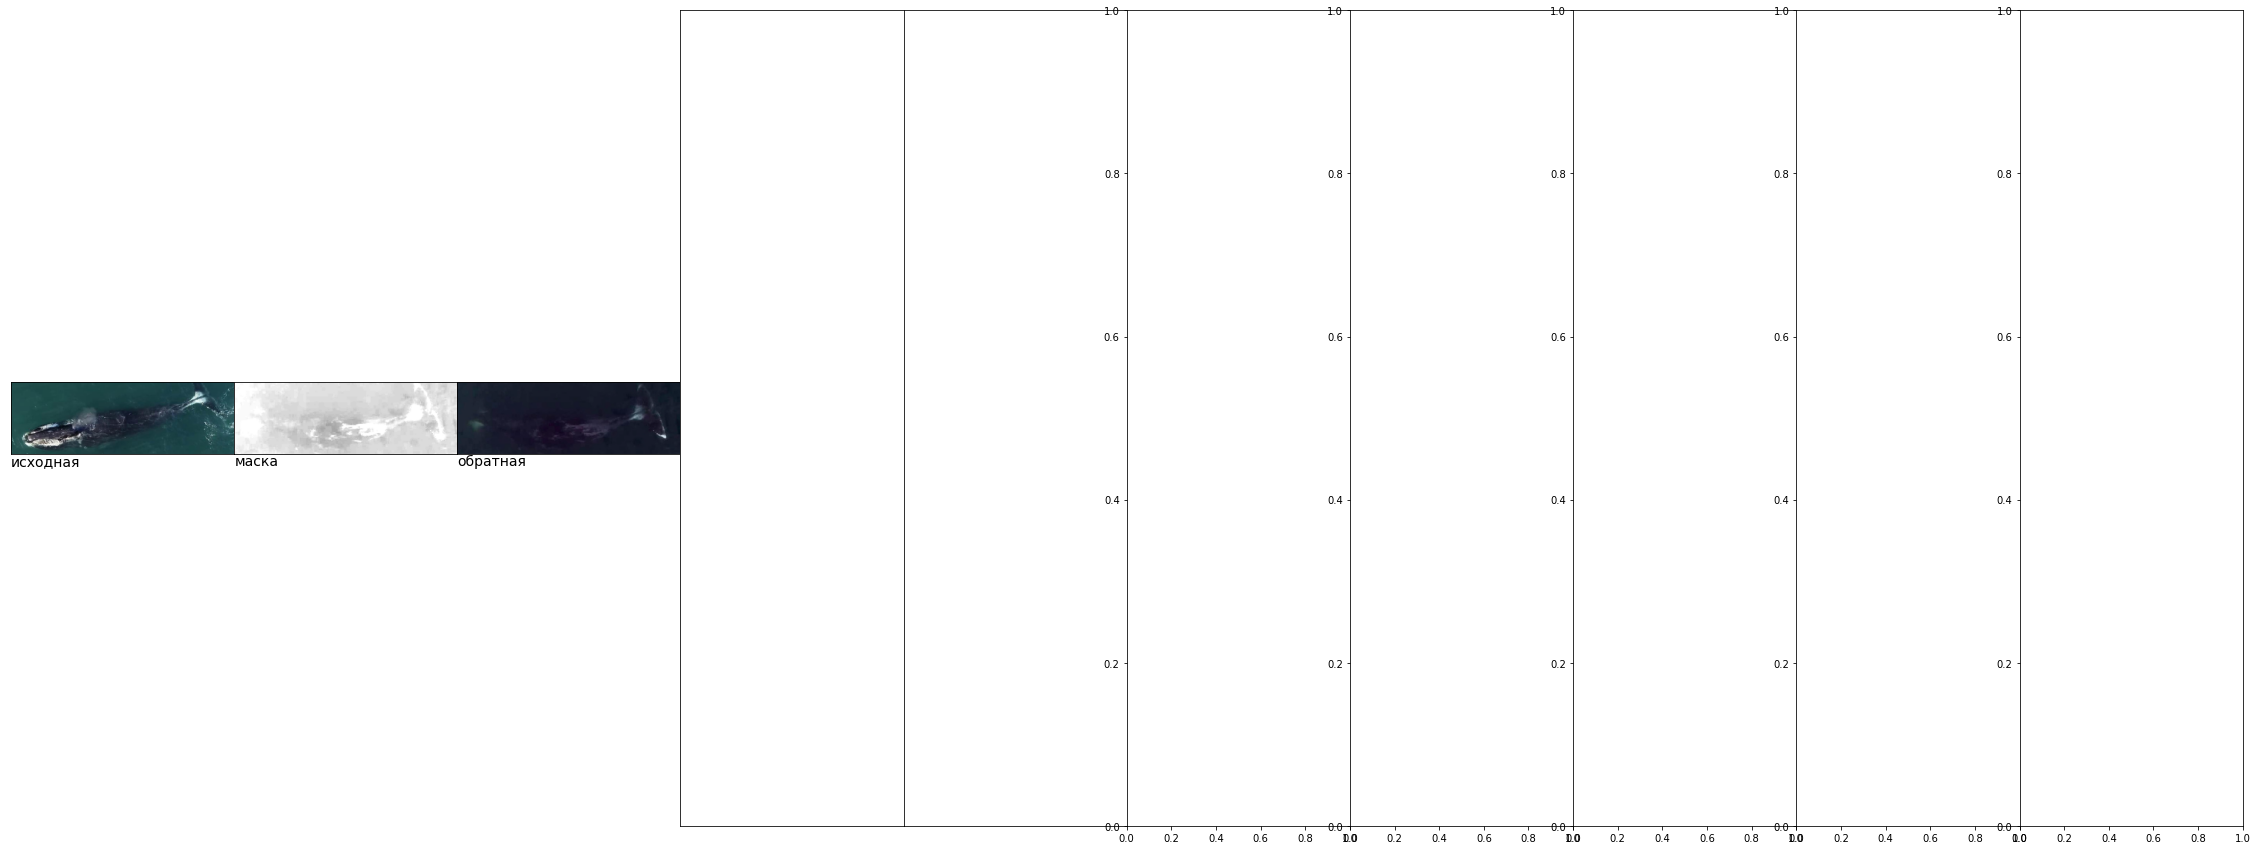

In [214]:
# выводим произвольные соответствующие картинки из массивов
num = 16
plot_images(num, X_train, Y_train, Y_train_color)

In [222]:
def crossvalid(res_model=None,criterion=None,optimizer=None,dataset=None,k_fold=101):
    
    train_score = pd.Series()
    val_score = pd.Series()
    
    total_size = len(df3)
    fraction = 1/k_fold
    seg = int(total_size * fraction)
    # tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
    # index: [trll,trlr],[vall,valr],[trrl,trrr]
    for i in range(k_fold):
        trll = 0
        trlr = i * seg
        vall = trlr
        valr = i * seg + seg
        trrl = valr
        trrr = total_size
        
        train_left_indices = list(range(trll,trlr))
        train_right_indices = list(range(trrl,trrr))
        
        train_indices = train_left_indices + train_right_indices
        val_indices = list(range(vall,valr))
        
        train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
        val_set = torch.utils.data.dataset.Subset(dataset,val_indices)
        
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        train_acc = train(res_model,criterion,optimizer,train_loader,val_loader,1)
        train_score.at[i] = train_acc
        val_acc = valid(res_model,criterion,optimizer,val_loader)
        val_score.at[i] = val_acc
    
    return train_score,val_score

In [221]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    dd = list(map(lambda x: x.cpu().detach().numpy(), train_history))
    plt.plot(dd, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]

    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [223]:
def train(res_model, criterion, optimizer, train_dataloader, test_dataloader, NUM_EPOCH=15):
    train_loss_log = []
    val_loss_log = []
    
    train_acc_log = []
    val_acc_log = []
    
    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = 0.

        for imgs, labels in train_dataloader:
            optimizer.zero_grad()

            imgs = imgs.cuda()
            labels = labels.cuda()

            y_pred = model(imgs)

            loss = criterion(y_pred, labels)
            loss.backward()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))
            
            train_pred += (y_pred.argmax(1) == labels).sum()

            optimizer.step()

        train_acc_log.append(train_pred / train_size)

        val_loss = 0.
        val_size = 0
        
        val_pred = 0.
        
        model.eval()
        
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                
                imgs = imgs.cuda()
                labels = labels.cuda()
                
                pred = model(imgs)
                loss = criterion(pred, labels)
                
                val_loss += loss.item()
                val_size += pred.size(0)
                
                val_pred += (pred.argmax(1) == labels).sum()
        

        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_pred / val_size)

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')
        


        print('Train loss:', (train_loss / train_size)*100)
        print('Val loss:', (val_loss / val_size)*100)
        print('Train acc:', (train_pred / train_size)*100)
        print('Val acc:', (val_pred / val_size)*100)
        
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [229]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 8)

model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: ignored

In [230]:
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

In [231]:
train_loader=X_train
valid_loader=Y_train

In [228]:
import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [236]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, 
                                                                 criterion, 
                                                                optimizer, 
                                                                 train_loader, 
                                                                 valid_loader, 
                                                                 15)

TypeError: ignored